# 정형 데이터와 함께 LLM 사용하기

## 파이썬으로 관계형 DB 다루기

In [1]:
import sqlite3
import pandas as pd
## 데이터베이스에 연결
database = 'chinook.db'


conn = sqlite3.connect(database)

## 테이블 가져오기
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                        WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


In [2]:
album_primary_keys= pd.read_sql("""PRAGMA table_info(albums);""",conn)
album_primary_keys

,cid,name,type,notnull,dflt_value,pk
0,0,AlbumId,INTEGER,1,None,1
1,1,Title,NVARCHAR(160),1,None,0
2,2,ArtistId,INTEGER,1,None,0


In [3]:
pd.read_sql("""
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;

""", conn)

,Country,Sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


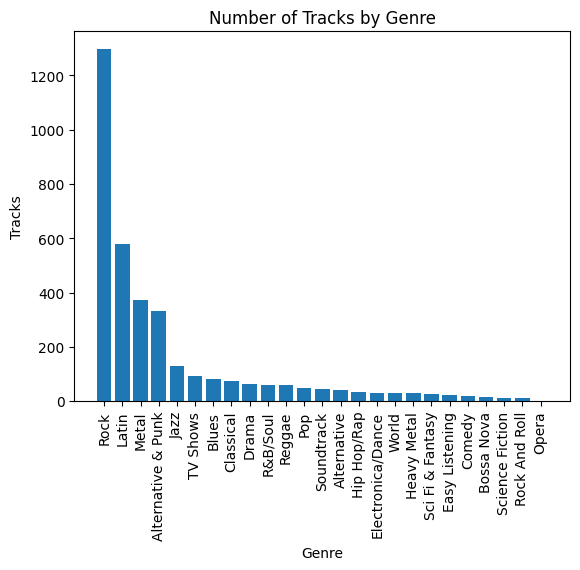

In [4]:
import matplotlib.pyplot as plt

# SQL 질의를 정의
sql = """
SELECT g.Name AS Genre, COUNT(t.TrackId) AS Tracks
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY Genre
ORDER BY Tracks DESC;
"""

# 데이터프레임을 생성
data = pd.read_sql(sql, conn)

# Plot the data as a bar chart
plt.bar(data.Genre, data.Tracks)
plt.title("Number of Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Tracks")
plt.xticks(rotation=90)
plt.show()

## 랭체인 에이전트 및 SQL 에이전트

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

#os.environ["HUGGINGFACEHUB_API_TOKEN"]
openai_api_key = os.environ['OPENAI_API_KEY']


In [71]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

db = SQLDatabase.from_uri('sqlite:///chinook.db')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
)

In [67]:
[tool.name for tool in toolkit.get_tools()]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [68]:
agent_executor.invoke("playlist_track 테이블 구조를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
먼저, playlist_track 테이블이 데이터베이스에 존재하는지 확인하기 위해 테이블 목록을 조회해야 합니다.  
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksplaylist_track 테이블이 데이터베이스에 존재하는 것을 확인했습니다. 이제 이 테이블의 구조를 조회해야 합니다.  
Action: sql_db_schema  
Action Input: "playlist_track"  
CREATE TABLE playlist_track (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES tracks ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES playlists ("PlaylistId")
)

/*
3 rows from playlist_track table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/이제 playlist_track 테이블의 구조를 한국어로 설명할 수 있습니다. 이 테이블은 두 개의 주요 열을 가지고 있습니다: PlaylistId와 TrackId. 이 두 열은 복합 기본 키로 설정되어 있으며, 각각 playlists 테이블과 tracks 테이블에 외래 키로 연결되어 있습니다. 

Final Answer: playlist_track 테이블은 두 개의 열(PlaylistId, TrackId)을 가지고 있으며, 이들은 복합 기본 키로 설정되어 있습니다

{'input': 'playlist_track 테이블 구조를 한국어로 알려줘',
 'output': 'playlist_track 테이블은 두 개의 열(PlaylistId, TrackId)을 가지고 있으며, 이들은 복합 기본 키로 설정되어 있습니다. PlaylistId는 playlists 테이블의 PlaylistId와, TrackId는 tracks 테이블의 TrackId와 외래 키 관계를 가지고 있습니다.'}

In [77]:
agent_executor.agent.runnable.get_prompts()

[PromptTemplate(input_variables=['agent_scratchpad', 'input'], partial_variables={'tools': "sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.\nsql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3\nsql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.\nsql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!", 'tool_names': 'sql_

In [84]:
agent_executor.invoke('매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
먼저, 매출이 저장된 데이터베이스의 테이블과 그 구조를 파악해야 합니다. 이를 위해 데이터베이스에 어떤 테이블이 있는지 확인할 필요가 있습니다. 

Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks매출 관련 데이터는 "invoices" 테이블이나 "invoice_items" 테이블에 있을 가능성이 높습니다. 먼저 "invoices" 테이블의 구조를 확인하여 매출과 국가 정보를 찾겠습니다.

Action: sql_db_schema  
Action Input: invoices  
CREATE TABLE invoices (
	"InvoiceId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"InvoiceDate" DATETIME NOT NULL, 
	"BillingAddress" NVARCHAR(70), 
	"BillingCity" NVARCHAR(40), 
	"BillingState" NVARCHAR(40), 
	"BillingCountry" NVARCHAR(40), 
	"BillingPostalCode" NVARCHAR(10), 
	"Total" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("InvoiceId"), 
	FOREIGN KEY("CustomerId") REFERENCES customers ("CustomerId")
)

/*
3 rows from invoices table:
InvoiceId	CustomerId	InvoiceDate	BillingAddress	BillingCity	BillingState	BillingCountry	BillingPosta

{'input': '매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘', 'output': '미국, 캐나다, 프랑스, 브라질, 독일'}

In [85]:
agent_executor.invoke('장르별 총 트랙 수와 평균 길이를 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
장르별 총 트랙 수와 평균 길이를 구하기 위해서는 데이터베이스에서 장르와 관련된 테이블을 찾아야 합니다. 먼저 데이터베이스의 테이블 목록을 확인하겠습니다.  
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks데이터베이스에는 여러 테이블이 있으며, 장르와 관련된 정보는 'genres' 테이블에 있을 가능성이 높습니다. 트랙 수와 평균 길이를 구하기 위해 'tracks' 테이블도 필요할 것입니다. 두 테이블의 스키마를 확인하겠습니다.  
Action: sql_db_schema  
Action Input: genres, tracks  
CREATE TABLE genres (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from genres table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFEREN

{'input': '장르별 총 트랙 수와 평균 길이를 한국어로 알려줘',
 'output': '- Rock: 총 트랙 수 1297개, 평균 길이 283910 밀리초\n- Jazz: 총 트랙 수 130개, 평균 길이 291755 밀리초\n- Metal: 총 트랙 수 374개, 평균 길이 309749 밀리초\n- Alternative & Punk: 총 트랙 수 332개, 평균 길이 234353 밀리초\n- Rock And Roll: 총 트랙 수 12개, 평균 길이 134643.5 밀리초\n- Blues: 총 트랙 수 81개, 평균 길이 270359.8 밀리초\n- Latin: 총 트랙 수 579개, 평균 길이 232859.3 밀리초\n- Reggae: 총 트랙 수 58개, 평균 길이 247177.8 밀리초\n- Pop: 총 트랙 수 48개, 평균 길이 229034.1 밀리초\n- Soundtrack: 총 트랙 수 43개, 평균 길이 244370.9 밀리초\n- Bossa Nova: 총 트랙 수 15개, 평균 길이 219590 밀리초\n- Easy Listening: 총 트랙 수 24개, 평균 길이 189164.2 밀리초\n- Heavy Metal: 총 트랙 수 28개, 평균 길이 297452.9 밀리초\n- R&B/Soul: 총 트랙 수 61개, 평균 길이 220066.9 밀리초\n- Electronica/Dance: 총 트랙 수 30개, 평균 길이 302985.8 밀리초\n- World: 총 트랙 수 28개, 평균 길이 224923.8 밀리초\n- Hip Hop/Rap: 총 트랙 수 35개, 평균 길이 178176.3 밀리초\n- Science Fiction: 총 트랙 수 13개, 평균 길이 2625549.1 밀리초\n- TV Shows: 총 트랙 수 93개, 평균 길이 2145041.0 밀리초\n- Sci Fi & Fantasy: 총 트랙 수 26개, 평균 길이 2911783.0 밀리초\n- Drama: 총 트랙 수 64개, 평균 길이 2575283.8 밀리초

## 프롬프트 엔지니어링

In [86]:
create_sql_agent?

Signature:
create_sql_agent(
    llm: 'BaseLanguageModel',
    toolkit: 'Optional[SQLDatabaseToolkit]' = None,
    agent_type: "Optional[Union[AgentType, Literal['openai-tools', 'tool-calling']]]" = None,
    callback_manager: 'Optional[BaseCallbackManager]' = None,
    prefix: 'Optional[str]' = None,
    suffix: 'Optional[str]' = None,
    format_instructions: 'Optional[str]' = None,
    input_variables: 'Optional[List[str]]' = None,
    top_k: 'int' = 10,
    max_iterations: 'Optional[int]' = 15,
    max_execution_time: 'Optional[float]' = None,
    early_stopping_method: 'str' = 'force',
    verbose: 'bool' = False,
    agent_executor_kwargs: 'Optional[Dict[str, Any]]' = None,
    extra_tools: 'Sequence[BaseTool]' = (),
    *,
    db: 'Optional[SQLDatabase]' = None,
    prompt: 'Optional[BasePromptTemplate]' = None,
    **kwargs: 'Any',
) -> 'AgentExecutor'
Docstring:
Construct a SQL agent from an LLM and toolkit or database.

Args:
    llm: Language model to use for the agent. If a

In [87]:
prompt_prefix = """ 
##Instructions:
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
As part of your final answer, ALWAYS include an explanation of how to got to the final answer, including the SQL query you run. Include the explanation and the SQL query in the section that starts with "Explanation:".

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don\'t know" as the answer.

##Tools:

"""

prompt_format_instructions = """ 
Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Explanation:

<===Beging of an Example of Explanation:

I joined the invoices and customers tables on the customer_id column, which is the common key between them. This will allowed me to access the Total and Country columns from both tables. Then I grouped the records by the country column and calculate the sum of the Total column for each country, ordered them in descending order and limited the SELECT to the top 5.

```sql
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
```

===>End of an Example of Explanation
"""

In [90]:
agent_executor = create_sql_agent(
    prefix=prompt_prefix,
    format_instructions = prompt_format_instructions,
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    top_k=10
)

result = agent_executor.invoke("가장 많이 팔린 앨범 5종과 그 앨범들 각각의 아티스트를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
I need to identify the most sold albums and their respective artists. This likely involves querying an albums table and possibly a related artists table. First, I will list the tables in the database to see what is available.

Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksI have identified the tables available in the database, particularly the "albums" and "artists" tables, which are likely needed to answer the question regarding the most sold albums and their respective artists. Now, I will check the schema of the "albums" and "artists" tables to understand their structure and the fields I can use.

Action: sql_db_schema  
Action Input: "albums, artists"  
CREATE TABLE albums (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") R

In [120]:
from IPython.display import Markdown, HTML, display 
def printmd(string):
    display(Markdown(string))
printmd(result['output'])

가장 많이 팔린 앨범 5종과 그 앨범들 각각의 아티스트는 다음과 같습니다: 
1. Minha Historia - Chico Buarque (27)
2. Greatest Hits - Lenny Kravitz (26)
3. Unplugged - Eric Clapton (25)
4. Acústico - Titãs (22)
5. Greatest Kiss - Kiss (20)

## 도구 추가하기

In [109]:
!pip install -U langchain-experimental langsmith

   ---------------------------------------- 0.0/140.4 kB ? eta -:--:--
   ----------- --------------------------- 41.0/140.4 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 140.4/140.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.81
    Uninstalling langsmith-0.1.81:
      Successfully uninstalled langsmith-0.1.81



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
from langchain.tools.file_management import (
    ReadFileTool,
    CopyFileTool,
    DeleteFileTool,
    MoveFileTool,
    WriteFileTool,
    ListDirectoryTool,
)
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.agents.agent_toolkits import FileManagementToolkit

working_directory  = os.getcwd()

tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"],).get_tools()
tools.append(
    PythonREPLTool())


tools.extend(SQLDatabaseToolkit(db=db, llm=llm).get_tools())
tools

[ReadFileTool(root_dir='D:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 WriteFileTool(root_dir='D:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 ListDirectoryTool(root_dir='D:\\GitHub\\ychoi-kr\\Building-LLM-Powered-Applications-ko'),
 PythonREPLTool(),
 QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000023EEB0472D0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Inp

In [100]:
[tool.name for tool in tools]

['read_file',
 'write_file',
 'list_directory',
 'Python_REPL',
 'sql_db_query',
 'sql_db_schema',
 'sql_db_list_tables',
 'sql_db_query_checker']

In [106]:
AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION?

Type:        AgentType
String form: AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION
Length:      43
File:        c:\users\yong\appdata\local\programs\python\python311\lib\site-packages\langchain\agents\agent_types.py
Docstring:  
.. deprecated:: 0.1.0 Use ``Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc.`` instead.

An enum for agent types.

See documentation: https://python.langchain.com/docs/modules/agents/agent_types/

In [113]:
# https://smith.langchain.com/에서 랭스미스 API 키 발급받고
# .env 파일에 LANGSMITH_API_KEY를 등록한 뒤에 다음을 실행하세요.

load_dotenv()
os.environ["LANGSMITH_API_KEY"][:5]

'lsv2_'

In [118]:
from langchain import hub
from langchain.agents import create_structured_chat_agent

prompt = hub.pull("hwchase17/structured-chat-agent")

agent = create_structured_chat_agent(
    llm, tools, prompt
)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)
agent_executor.invoke({"input": "Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요."})



> Entering new AgentExecutor chain...
Thought: First, I need to query the Chinook database to get the top 5 countries by sales. After retrieving the data, I will create a Pandas DataFrame and then plot a bar chart using Matplotlib. Finally, I will save the figure as "figure.png" in the current working directory.

Action:
```json
{
  "action": "sql_db_list_tables",
  "action_input": {}
}
```albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksAction:
```json
{
  "action": "sql_db_query",
  "action_input": "SELECT BillingCountry, SUM(Total) as TotalSales FROM invoices GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;"
}
```[('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1), ('Germany', 156.48)]Action:
```json
{
  "action": "Python_REPL",
  "action_input": "import pandas as pd; import matplotlib.pyplot as plt; data = [('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1),

{'input': 'Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요.',
 'output': "The bar chart for the top 5 countries by sales has been created and saved as 'figure.png' in the current working directory."}